In [20]:
import pandas as pd
import math
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression, LinearRegression

%matplotlib inline

In [2]:
df = pd.read_excel('./Data/File1.xlsx')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 28 columns):
Account Number        42 non-null int64
PortID                42 non-null object
Remaining Balance     42 non-null float64
interests Fees        42 non-null float64
Date Opened           42 non-null datetime64[ns]
Charge Off Date       42 non-null datetime64[ns]
Last Pay Date         38 non-null datetime64[ns]
Last Pay Amount       42 non-null float64
Last Activity Date    42 non-null datetime64[ns]
Interest Rate %       42 non-null float64
Issuer                42 non-null object
Merchant              42 non-null object
FCFRA Date            42 non-null datetime64[ns]
OOS Date              42 non-null datetime64[ns]
Account Type          42 non-null object
Last Name             42 non-null object
First Name            42 non-null object
Middle Name           28 non-null object
Address               42 non-null object
City                  42 non-null object
State                 42 n

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c1ae86048>,
      dtype=object)

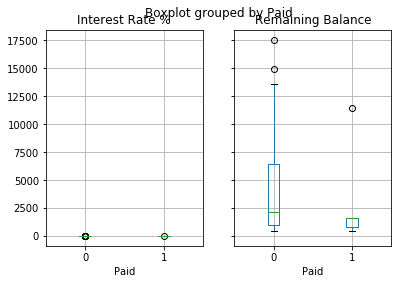

In [4]:
df.boxplot(['Interest Rate %', 'Remaining Balance'], by='Paid')

In [5]:
# Now, let's build our GLM
indep_vars = ['Interest Rate %', 'Remaining Balance']
X = sm.add_constant(df[indep_vars]) # Must add the intercept
y = df.Paid

glm_logit = sm.GLM(y, 
                   X,
                   sm.families.Binomial(sm.families.links.logit))
results_logit = glm_logit.fit()

results_logit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   Paid   No. Observations:                   42
Model:                            GLM   Df Residuals:                       39
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -15.117
Date:                Mon, 01 Oct 2018   Deviance:                       30.235
Time:                        14:16:04   Pearson chi2:                     43.0
No. Iterations:                     5   Covariance Type:             nonrobust
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -1.6212      1.186     -1.367      0.171      -3.945       0.702
Interest Rate %      -0.8448      9.688     -0.087      0.931     -19.834      18.144
Remaining Balance -7.782e-05      0.000     -0.604      0.546      -0.000       0.000
=====================================================================================
"""

- As the interest rate increases by 1% the odds of them paying back decrease by 84%

In [6]:
# Dummy up the Cycle as this is an important feature

df = pd.get_dummies(df, columns = ['Cycle'])
df.head()

,Account Number,PortID,Remaining Balance,interests Fees,Date Opened,Charge Off Date,Last Pay Date,Last Pay Amount,Last Activity Date,Interest Rate %,...,State,Zip,County,SSN,Home Phone,Employer Phone,Paid,Cycle_QUATERNARY,Cycle_SECONDARY,Cycle_TERTIARY
0,4071580080012050,FUS0813,6020.73,1352.43,1989-10-17,2005-12-30,NaT,200.0,2006-06-28,0.0800,...,CO,80203-4205,DENVER,287567934,3039418940,3036752373,0,0,0,1
1,4253294210011880,FUS0739,778.20,160.41,2005-06-03,2006-03-31,NaT,0.0,2005-06-03,0.0800,...,CO,80011-9052,ADAMS,523755675,3036800451,3036803635,0,0,0,1
2,4266493601904600,FUS0422,404.68,711.87,1995-09-01,2003-04-30,2002-09-08,0.0,2002-09-08,0.1924,...,CO,80221-2732,ADAMS,523710822,3034879164,9999999999,0,0,1,0
3,4266513023392740,FUS0560,502.26,718.72,1999-11-17,2003-12-31,2003-08-07,0.0,2003-08-07,0.1999,...,CO,80206-3522,DENVER,522234200,3036980983,9999999999,0,0,0,1
4,4266812001671530,FUS0722,6482.89,1654.38,1998-09-13,2005-09-30,2005-02-10,150.0,2005-02-10,0.0800,...,CO,80229-7910,ADAMS,522533406,3032875899,3032886677,0,0,0,1


In [7]:
# Now, let's build our GLM
indep_vars = ['Cycle_QUATERNARY','Cycle_SECONDARY','Cycle_TERTIARY']
X = sm.add_constant(df[indep_vars]) # Must add the intercept
y = df.Paid

glm_logit = sm.GLM(y, 
                   X,
                   sm.families.Binomial(sm.families.links.logit))
results_logit = glm_logit.fit()

results_logit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   Paid   No. Observations:                   42
Model:                            GLM   Df Residuals:                       39
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12.897
Date:                Mon, 01 Oct 2018   Deviance:                       25.793
Time:                        14:16:18   Pearson chi2:                     39.0
No. Iterations:                    22   Covariance Type:             nonrobust
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.1673   2.95e+04  -5.67e-06      1.000   -5.78e+04    5.78e+04
Cycle_QUATERNARY    24.4173   8.44e+04      0.000      1.000   -1.65e+05    1.65e+05
Cycle_SECONDARY    -22.5827   3.96e+04     -0.001      1.000   -7.76e+04    7.76e+04
Cycle_TERTIARY      -2.0018   2.95e+04  -6.79e-05      1.000   -5.78e+04    5.78e+04
====================================================================================
"""

In [8]:
num_cols = df.columns[[np.issubdtype(dt, np.number) for dt in df.dtypes]]

drop_cols = [key for key in dict(df.dtypes) 
                if dict(df.dtypes)[key] in ['datetime64[ns]', 'object']]

# Add phone numbers to drop list
# drop_cols.extend(('Employer Phone', 'Home Phone'))

In [9]:
X = df.drop(columns = drop_cols)
y = df['Paid']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Naive Bayes

In [18]:
# Instantiate our model!
nb = MultinomialNB()

# Fit our model!
model = nb.fit(X_train, y_train)

# Generate our predictions!
predictions = model.predict(X_test)

print("Train Score {0:.2f}".format(model.score(X_train, y_train)))

print("Test Score {0:.2f}".format(model.score(X_test, y_test)))

Train Score 0.52
Test Score 0.38


### Confusion Matrix

In [16]:
confusion_matrix(y_test, predictions)

array([[5, 7],
       [1, 0]])

In [17]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 5
False Positives: 7
False Negatives: 1
True Positives: 0


### Fitting and making predictions with the Logistic Regression model.

---

In [22]:
# Step 1: Instantiate our model.
logreg = LogisticRegression()

# Step 2: Fit our model.
logreg.fit(X_train, y_train)

print('Logreg intercept:', logreg.intercept_)
print('Logreg coef(s):', logreg.coef_)

Logreg intercept: [-8.34348486e-32]
Logreg coef(s): [[-3.95109348e-16 -4.34541235e-28  2.73134005e-28 -3.61542562e-30
  -6.39757007e-33 -1.07901563e-22 -3.11324667e-22 -7.34090371e-22
   1.36638235e-31  3.38797363e-32 -1.87794669e-32 -9.85351180e-32]]


In [27]:
print('Logreg predicted probabilities:', logreg.predict(X_train.head()))

Logreg predicted probabilities: [0 0 0 0 0]


In [24]:
print('Logreg predicted probabilities:', logreg.predict_proba(X_train.head(5)))

Logreg predicted probabilities: [[0.84368009 0.15631991]
 [0.84836543 0.15163457]
 [0.88558859 0.11441141]
 [0.84878306 0.15121694]
 [0.88878605 0.11121395]]
